In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
#from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq


os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen-2.5-32b")

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
#llm = ChatOpenAI(model="gpt-4o")

result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003707896, 'queue_time': 0.23464668900000002, 'total_time': 0.053707896}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-2ef06fdc-4dde-4f52-8d9b-993a272bd600-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [2]:
import re
import requests
from youtube_transcript_api import YouTubeTranscriptApi
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [3]:
def extract_video_id(url):
    """Extracts the video ID from a YouTube URL using regex."""
    patterns = [
        r"(?:v=|\/)([0-9A-Za-z_-]{11}).*",
        r"(?:embed\/)([0-9A-Za-z_-]{11})",
        r"(?:watch\?v=)([0-9A-Za-z_-]{11})",
        r"youtu\.be\/([0-9A-Za-z_-]{11})"
    ]
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    return None

In [4]:
# ✅ Function to Fetch YouTube Transcript (No API Key Required)
def get_video_transcript(video_id):
    """Fetches the transcript of a YouTube video using YouTubeTranscriptApi."""
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return ' '.join([item['text'] for item in transcript])
    except Exception as e:
        print(f"❌ Error getting transcript: {e}")
        return None

In [5]:
# ✅ Function to Fetch Video Metadata (Title, Author) Without API Key
def get_video_info(url):
    """Extracts video metadata and transcript from YouTube without API key."""
    video_id = extract_video_id(url)
    if not video_id:
        return None, "Invalid YouTube URL"

    try:
        # Fetch Transcript
        transcript = get_video_transcript(video_id)
        if not transcript:
            return None, "Could not get video transcript"

        # Fetch Video Metadata using OEmbed (No API Key Required)
        oembed_url = f'https://www.youtube.com/oembed?url=https://www.youtube.com/watch?v={video_id}&format=json'
        response = requests.get(oembed_url)

        if response.status_code != 200:
            return None, "Could not fetch video metadata"

        video_data = response.json()
        return {
            'title': video_data.get('title', 'Unknown Title'),
            'author': video_data.get('author_name', 'Unknown Author'),
            'url': f'https://www.youtube.com/watch?v={video_id}'
        }, transcript

    except Exception as e:
        print(f"❌ Error extracting video info: {e}")
        return None, str(e)

In [6]:
def generate_blog(state):
    """Convert transcript into a structured blog."""
    transcript = state["messages"][-1].content  # Get latest transcript

    prompt = f"""
    Convert this transcript into a well-structured blog:
    
    Transcript:
    {transcript}

    Structure:
    - Title
    - Introduction
    - Key Insights
    - Conclusion
    """

    return MessagesState(messages=[llm.invoke([sys_msg] + state["messages"] + [HumanMessage(content=prompt)])])

In [7]:
def review_blog(state):
    """Improve blog clarity, grammar, and engagement."""
    blog_text = state["messages"][-1].content  # Extract AI-generated blog

    prompt = f"""
    Review and improve clarity, grammar, and engagement for the following blog:
    
    {blog_text}

    Provide an improved version.
    """

    return MessagesState(messages=[llm.invoke([sys_msg] + state["messages"] + [HumanMessage(content=prompt)])])

In [8]:
def publish_blog(state):
    """Simulates publishing the blog."""
    return {"messages": [AIMessage(content="✅ Blog published successfully! 🎉")]}

In [9]:
tools = [extract_video_id, get_video_info]

llm_with_tools=llm.bind_tools(tools)

In [10]:
# System message
sys_msg = SystemMessage(content="You are a professional blog editor tasked with writing a blog from a YouTube video's transcript.")


# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

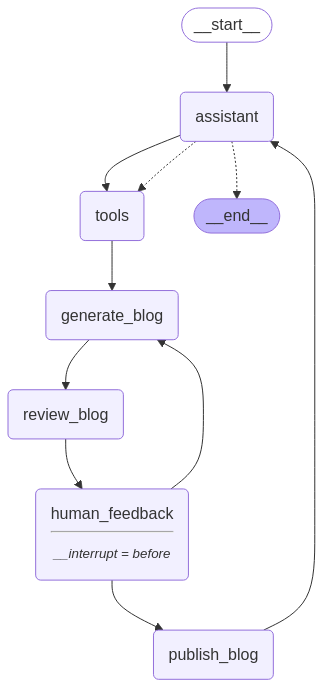

In [11]:
# Graph
builder = StateGraph(MessagesState)

# ✅ Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)
builder.add_node("generate_blog", generate_blog)
builder.add_node("review_blog", review_blog)
builder.add_node("publish_blog", publish_blog)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_edge("tools", "generate_blog")
builder.add_edge("generate_blog", "review_blog")
builder.add_edge("review_blog", "human_feedback")
builder.add_edge("human_feedback", "publish_blog")
builder.add_edge("human_feedback", "generate_blog")
builder.add_edge("publish_blog", "assistant")

builder.add_conditional_edges(
    #"human_feedback",
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)


memory = MemorySaver()


# human in the loop
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))



In [12]:
# ✅ Take YouTube Video Link as User Input
youtube_url = input("Enter YouTube Video URL: ").strip()


video_info, transcript = get_video_info(youtube_url)


if not video_info:
    print(f"❌ {transcript}")  # Display the error message
else:
    print(f"✅ Video Found: {video_info['title']} by {video_info['author']}")
    print(f"🔗 Video URL: {video_info['url']}")


# Thread
thread = {"configurable": {"thread_id": "1"}}



# ✅ Prepare Initial Input as a Dictionary
initial_state = {"messages": [HumanMessage(content=youtube_url)]}  # Ensure dictionary format



# ✅ Run the graph until the first interruption
for event in graph.stream(initial_state, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()   



## get user input
user_input=input("Tell me how you want to update the blog:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()     





✅ Video Found: Live AI CRASH COURSE-Most Extensive Series For Data Science, Generative And Agentic AI by Krish Naik
🔗 Video URL: https://www.youtube.com/watch?v=m12M904RNRA
================================ Human Message =================================

https://www.youtube.com/watch?v=m12M904RNRA
================================== Ai Message ==================================
Tool Calls:
  get_video_info (call_amzy)
 Call ID: call_amzy
  Args:
    url: https://www.youtube.com/watch?v=m12M904RNRA
================================= Tool Message =================================
Name: get_video_info

[{"title": "Live AI CRASH COURSE-Most Extensive Series For Data Science, Generative And Agentic AI", "author": "Krish Naik", "url": "https://www.youtube.com/watch?v=m12M904RNRA"}, "hello all my name is krishak and welcome to my YouTube channel so guys I am super excited to announce this amazing free live AI crash course which will be the most extensive series for data science generative Ai an